In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from PIL import Image, ImageChops, ImageEnhance
import os 
import joblib


In [2]:
PATH_IMG = '/Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/'


In [23]:
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []
for label in data_label:
    # print(label)
    # print(os.listdir(PATH_IMG+label))
    for img_file in os.listdir(PATH_IMG+label):
        img_lst.append(PATH_IMG+label+'/'+img_file)
        label_lst.append(label)
    # print(label_lst)


df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()

,img,label
0,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au
1,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au
2,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au
3,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au
4,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au


In [26]:
import os
from PIL import Image, UnidentifiedImageError

PATH_RESAVED = '/Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/resave/'

def resave(quality):
    for index, row in df.iterrows():
        img_file = row['img']
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            try:
                img = Image.open(img_file).convert('RGB')
                img_file_name = os.path.basename(img_file)
                resaved_name = os.path.splitext(img_file_name)[0] + 'resaved' + '.jpg'
                img.save(os.path.join(PATH_RESAVED, resaved_name), 'JPEG', quality=quality, optimize=True)
            except UnidentifiedImageError:
                print(f"Cannot identify image file {img_file}")
        else:
            print(f"Skipping non-image file {img_file}")

# Run the function with the desired quality
resave(90)


Skipping non-image file /Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Au/Thumbs.db
Skipping non-image file /Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Tp/Tp_S_NNN_S_B_ani00044_ani00044_00164.tif
Skipping non-image file /Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Tp/Tp_S_NRD_S_N_pla20019_pla20019_02390.tif
Skipping non-image file /Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Tp/Tp_D_NRD_M_N_sec00057_nat00001_00078.tif
Skipping non-image file /Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Tp/Tp_S_NNN_S_B_art00070_art00070_01241.tif
Skipping non-image file /Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Tp/Tp_D_NRD_S_B_nat20039_arc20055_02239.tif
Skipping non-image file /Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Tp/Tp_D_NRD_S_N_sec00001_cha00042_00001.tif
Skipping non-image file /Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Tp/Tp_S_NNN_S_N_cha00043_cha00043_00363.tif
Skippin

In [27]:
df['img_resaved'] = df['img'].apply(lambda x: PATH_RESAVED+ x.split('/')[-1].split('.')[0] + 'resaved' + '.jpg')
df.head()

,img,label,img_resaved
0,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au,/Users/nafeessiddiqui/PycharmProjects/pythonPr...
1,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au,/Users/nafeessiddiqui/PycharmProjects/pythonPr...
2,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au,/Users/nafeessiddiqui/PycharmProjects/pythonPr...
3,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au,/Users/nafeessiddiqui/PycharmProjects/pythonPr...
4,/Users/nafeessiddiqui/PycharmProjects/pythonPr...,Au,/Users/nafeessiddiqui/PycharmProjects/pythonPr...


In [28]:
def img_difference(org, resaved):
    org_img = Image.open(org).convert('RGB')
    resaved_img = Image.open(resaved)
    try:
        
        diff = ImageChops.difference(org_img, resaved_img)
    except Exception as e:
        print(org, resaved)
        print(e)
        return None
    # diff= ImageEnhance.Brightness(diff).enhance(250.0)
    extrema = diff.getextrema()
    # print(extrema)
    # lst = [ex[1] for ex in extrema]
    max_diff = max([ex[1] for ex in extrema])
    # print(lst, max_diff)
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)
    enhancer = ImageEnhance.Sharpness(diff)
    diff = enhancer.enhance(1.5)
    return diff

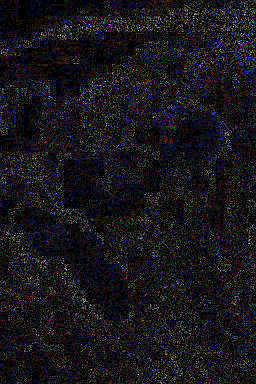

In [29]:
img_difference('/Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/Au/Au_pla_30535.jpg', '/Users/nafeessiddiqui/PycharmProjects/pythonProject8/CASIA2/resavedd/Au_pla_30535resaved.jpg')


In [30]:
# divide dataset into train and tes
from PIL import Image, ImageChops, ImageEnhance, UnidentifiedImageError

def prep_dataset():
    X = []
    y = []
    valid_extensions = ('.jpg', '.jpeg', '.png')
    
    for index, row in df.iterrows():
        if row['img'].lower().endswith(valid_extensions) and row['img_resaved'].lower().endswith(valid_extensions):
            try:
                x = img_difference(row['img'], row['img_resaved']).resize((128, 128))
                X.append(np.array(x).flatten()/255.0)
                y.append([1, 0] if row['label'] == 'Au' else [0, 1])
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Skipping file {row['img']} due to error: {e}")
    return np.array(X), np.array(y)

In [31]:

# Prepare dataset
X, y = prep_dataset()

In [33]:
joblib.dump(X, 'X_90.joblib')
joblib.dump(y, 'y.joblib')

['y.joblib']

In [34]:
# load X and y

X = joblib.load('X_90.joblib')
y = joblib.load('y.joblib')

In [35]:

from sklearn.model_selection import train_test_split
X=np.array(X)
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = [self.X[k] for k in indexes]
        y = [self.y[k] for k in indexes]
        return np.array(X), np.array(y)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)

In [37]:
X_train=X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test=X_test.reshape(X_test.shape[0], 128, 128, 3)

y_train=y_train.reshape(y_train.shape[0], 2)
y_test=y_test.reshape(y_test.shape[0], 2)

In [38]:
train_data = DataGenerator(X_train, y_train)
val_data = DataGenerator(X_test, y_test)

In [39]:
import gc

del(X)
del(y)
gc.collect()

16

In [40]:
# custom model for image classification

def build_model():

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

In [41]:
model = build_model()

model.summary()

/Users/nafeessiddiqui/PycharmProjects/pythonProject8/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,778 (12.47 MB)

 Trainable params: 3,267,778 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=15, validation_data=val_data, callbacks=[cal1, cal2])
history =  history.history

Epoch 1/15


/Users/nafeessiddiqui/PycharmProjects/pythonProject8/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


237/237 ━━━━━━━━━━━━━━━━━━━━ 46s 190ms/step - accuracy: 0.8085 - loss: 0.3538 - val_accuracy: 0.8612 - val_loss: 0.2964
Epoch 2/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.8641 - loss: 0.2762 - val_accuracy: 0.8702 - val_loss: 0.2714
Epoch 3/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 216ms/step - accuracy: 0.8797 - loss: 0.2509 - val_accuracy: 0.8845 - val_loss: 0.2575
Epoch 4/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy: 0.8857 - loss: 0.2261 - val_accuracy: 0.8734 - val_loss: 0.3157
Epoch 5/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9142 - loss: 0.1824 - val_accuracy: 0.8962 - val_loss: 0.2747
Epoch 6/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 49s 204ms/step - accuracy: 0.9216 - loss: 0.1768 - val_accuracy: 0.9004 - val_loss: 0.2848
Epoch 7/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 49s 207ms/step - accuracy: 0.9468 - loss: 0.1241 - val_accuracy: 0.8978 - val_loss: 0.2708
Epoch 8/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 52s 220ms/step - accuracy: 0.9547 - loss: 0.1034 - val

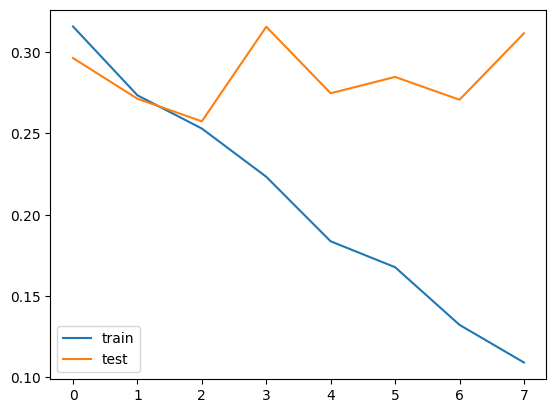

In [43]:
#  plot the loss and accuracy

plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

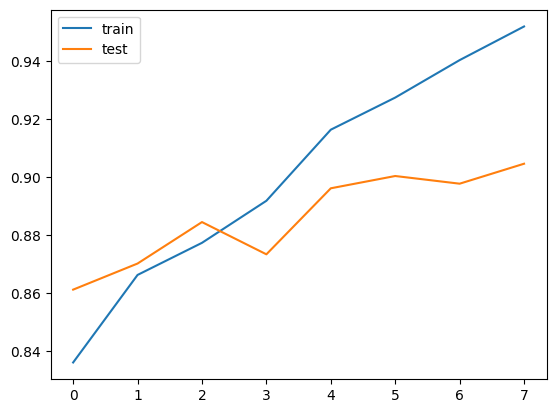

In [44]:
# plot the accuracy

plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [45]:
# Vgg16 model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False


model = base_model.output
# model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(512, activation='relu')(model)
model = tf.keras.layers.Dense(2, activation='softmax')(model)


model = Model(inputs=base_model.input, outputs=model)

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)

In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,803,336 (37.40 MB)

 Trainable params: 3,267,778 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,535,558 (24.93 MB)

In [47]:
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model_vgg16.keras', monitor='val_loss', save_best_only=True)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=60, validation_data=val_data)#, callbacks=[cal1, cal2])

Epoch 1/60
237/237 ━━━━━━━━━━━━━━━━━━━━ 47s 196ms/step - accuracy: 0.8871 - loss: 0.2691 - val_accuracy: 0.8798 - val_loss: 0.2684
Epoch 2/60
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 214ms/step - accuracy: 0.9071 - loss: 0.2025 - val_accuracy: 0.8829 - val_loss: 0.2857
Epoch 3/60
237/237 ━━━━━━━━━━━━━━━━━━━━ 46s 193ms/step - accuracy: 0.9192 - loss: 0.1820 - val_accuracy: 0.8962 - val_loss: 0.2799
Epoch 4/60
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 228ms/step - accuracy: 0.9203 - loss: 0.1710 - val_accuracy: 0.8681 - val_loss: 0.3952
Epoch 5/60
237/237 ━━━━━━━━━━━━━━━━━━━━ 56s 237ms/step - accuracy: 0.9366 - loss: 0.1450 - val_accuracy: 0.8904 - val_loss: 0.3711
Epoch 6/60
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 258ms/step - accuracy: 0.9437 - loss: 0.1366 - val_accuracy: 0.8893 - val_loss: 0.3457
Epoch 7/60
237/237 ━━━━━━━━━━━━━━━━━━━━ 61s 254ms/step - accuracy: 0.9516 - loss: 0.1161 - val_accuracy: 0.9015 - val_loss: 0.3306
Epoch 8/60
237/237 ━━━━━━━━━━━━━━━━━━━━ 65s 274ms/step - accuracy: 0.9557 - loss: 0